# Evaluation VPropNN

# Load Data

In [1]:
import tensorflow as tf

### Configuration
create_dataset = False

def in_google_colab():
    """Checks if the code is running in Google Colab

    Returns:
        bool: _description_
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

if in_google_colab():
    print("Running in Google Colab")
    # Install necessary packages in Google Colab
    !rm -r sample_data/
    !git clone https://github.com/naderinho/anesthesia_anomaly_detection
    !cp -r anesthesia_anomaly_detection/* .
    !rm -r anesthesia_anomaly_detection/
    !pip install vitaldb
    create_dataset = False
else:
    print("Running locally")

### Datasetpath
directory = 'data/'
datasetpath = 'dataset02/'
vitaldbpath = 'vitaldb_tiva/'

### Import the necessary libraries
import numpy as np
import pandas as pd
import vitaldb as vf
import matplotlib.pyplot as plt
import pickle

### Custom functions
import modules as md

Running locally


In [2]:
### Load the datasets
bis = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bis.load('00_bis.npz')

info = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info.load('01_info.npz')

info_non_norm = md.infoImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
info_non_norm.load('01_info_norm_none.npz')

bloodpressure = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
bloodpressure.load('02_bloodpressure.npz')

etCO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
etCO2.load('02_etCO2.npz')

spO2 = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
spO2.load('02_spO2.npz')

hr = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
hr.load('02_hr.npz')

propofolrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
propofolrate.load('03_propofol_rate.npz')

remifentanilrate = md.VitalImport(directory= directory, dataset=datasetpath, vitalpath=vitaldbpath)
remifentanilrate.load('03_remifentanil_rate.npz')

train_index, val_index, test_index = bis.split(np.array(bis.index))

In [3]:
# Load test prediction data
with open('models/VitalNN/bs4/prediction.pkl', 'rb') as f:
    y_pred = pickle.load(f)

from utils.evaluation import phases_report, phases_report_std

# Seperate Data

## Seperate the Data in + 60 years and older patients

In [4]:
young_index_train = np.where(info_non_norm.train_dataset[:,1] <  60)
old_index_train   = np.where(info_non_norm.train_dataset[:,1] >= 60)

print(young_index_train[0].shape, old_index_train[0].shape)

young_index_val = np.where(info_non_norm.validation_dataset[:,1] <  60)
old_index_val   = np.where(info_non_norm.validation_dataset[:,1] >= 60)

print(young_index_val[0].shape, old_index_val[0].shape)

young_index_test = np.where(info_non_norm.test_dataset[:,1] <  60)
old_index_test   = np.where(info_non_norm.test_dataset[:,1] >= 60)

print(young_index_test[0].shape, old_index_test[0].shape)

(47,) (64,)
(10,) (10,)
(9,) (15,)


## Seperate the Data in Male and Female patients

In [5]:
m_index_train = np.where(info.train_dataset[:,0] == 0.5)
f_index_train = np.where(info.train_dataset[:,0] == -0.5)

print(m_index_train[0].shape, f_index_train[0].shape)

m_index_val = np.where(info.validation_dataset[:,0] == 0.5)
f_index_val = np.where(info.validation_dataset[:,0] == -0.5)

print(m_index_val[0].shape, f_index_val[0].shape)

m_index_test = np.where(info.test_dataset[:,0] == 0.5)
f_index_test = np.where(info.test_dataset[:,0] == -0.5)

print(m_index_test[0].shape, f_index_test[0].shape)

(74,) (37,)
(12,) (8,)
(18,) (6,)


## Seperate by BMI

In [6]:
bmi = 23

bmi_1_index_train = np.where(info_non_norm.train_dataset[:,4] < bmi)
bmi_2_index_train = np.where(info_non_norm.train_dataset[:,4] >= bmi)

print(bmi_1_index_train[0].shape, bmi_2_index_train[0].shape)

bmi_1_index_validation = np.where(info_non_norm.validation_dataset[:,4] < bmi)
bmi_2_index_validation = np.where(info_non_norm.validation_dataset[:,4] >= bmi)

print(bmi_1_index_validation[0].shape, bmi_2_index_validation[0].shape)

bmi_1_index_test = np.where(info_non_norm.test_dataset[:,4] < bmi)
bmi_2_index_test = np.where(info_non_norm.test_dataset[:,4] >= bmi)

print(bmi_1_index_test[0].shape, bmi_2_index_test[0].shape)

(55,) (56,)
(12,) (8,)
(12,) (12,)


# Gesamtfehler

In [7]:
all_rep = phases_report(y_pred, bis.test_dataset, propofolrate.test_dataset)
all_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,109.89,139.87,7.74,7.55,10.48,11.83
Induction,259.81,637.60,12.58,18.34,16.12,25.25
Maintenance,75.13,60.90,6.64,5.68,8.67,7.80
Recovery,245.89,361.57,11.91,13.46,15.68,19.02


In [8]:
all_rep_std = phases_report_std(all_rep, y_pred, bis.test_dataset, propofolrate.test_dataset)
all_rep_std

All      	min: 	 15 	max: 	 6
Induction 	min: 	 23 	max: 	 10
Maintenance 	min: 	 13 	max: 	 6
Recovery 	min: 	 19 	max: 	 22


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,56.67,82.42,2.11,2.54,2.61,3.31
Induction,255.35,403.81,5.86,8.45,6.17,7.29
Maintenance,39.63,43.11,1.80,2.15,2.12,2.51
Recovery,145.74,185.95,5.00,6.28,5.68,6.47


# MDPE

In [9]:
timefilter = (bis.test_dataset == 0.0)

groundtruth = np.copy(bis.test_dataset)
groundtruth[timefilter] = np.nan
groundtruth = groundtruth

y_pred[timefilter] = np.nan
y_pred_all = y_pred

mdpe_all = np.nanmedian((groundtruth - y_pred_all) / groundtruth * 100, axis=1)
mdpe_all_mean = np.nanmean(mdpe_all)
mdpe_all_std = np.nanstd(mdpe_all)
mdpe_m = np.nanmedian((groundtruth[m_index_test] - y_pred[m_index_test]) / groundtruth[m_index_test] * 100, axis=1)
mdpe_m_mean = np.nanmean(mdpe_m)
mdpe_m_std = np.nanstd(mdpe_m)
mdpe_f = np.nanmedian((groundtruth[f_index_test] - y_pred[f_index_test]) / groundtruth[f_index_test] * 100, axis=1)
mdpe_f_mean = np.nanmean(mdpe_f)
mdpe_f_std = np.nanstd(mdpe_f)

print("All: \t{:.2f} \t{:.2f}".format(mdpe_all_mean, mdpe_all_std))
print("M: \t{:.2f} \t{:.2f}".format(mdpe_m_mean, mdpe_m_std))
print("F: \t{:.2f} \t{:.2f}".format(mdpe_f_mean, mdpe_f_std))

All: 	-4.37 	10.75
M: 	-7.12 	8.76
F: 	3.90 	11.87


# Testing Age

## > 60 years

In [10]:
old_rep = phases_report(y_pred[old_index_test], bis.test_dataset[old_index_test], propofolrate.test_dataset[old_index_test])
old_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,113.10,138.97,7.77,7.10,10.63,11.79
Induction,258.99,624.85,12.31,17.37,16.09,25.00
Maintenance,73.35,47.75,6.52,4.92,8.56,6.91
Recovery,251.27,374.76,12.16,13.62,15.85,19.36


In [11]:
old_rep_std = phases_report_std(old_rep,y_pred[old_index_test], bis.test_dataset[old_index_test], propofolrate.test_dataset[old_index_test])
old_rep_std

All      	min: 	 9 	max: 	 0
Induction 	min: 	 14 	max: 	 5
Maintenance 	min: 	 7 	max: 	 5
Recovery 	min: 	 2 	max: 	 13


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,56.62,74.81,1.90,1.73,2.54,3.07
Induction,277.24,423.91,6.23,8.80,6.37,7.75
Maintenance,39.68,31.03,1.62,1.28,2.14,2.00
Recovery,120.21,148.20,3.56,4.92,3.62,4.70


## < 60 years

In [12]:
young_rep = phases_report(y_pred[young_index_test], bis.test_dataset[young_index_test], propofolrate.test_dataset[young_index_test])
young_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,105.03,141.25,7.70,8.23,10.25,11.88
Induction,266.68,660.01,13.33,20.05,16.33,25.69
Maintenance,77.76,79.34,6.82,6.76,8.82,8.91
Recovery,237.50,329.30,11.50,13.06,15.41,18.15


In [13]:
young_rep_std = phases_report_std(young_rep, y_pred[young_index_test], bis.test_dataset[young_index_test], propofolrate.test_dataset[young_index_test])
young_rep_std

All      	min: 	 7 	max: 	 3
Induction 	min: 	 7 	max: 	 2
Maintenance 	min: 	 8 	max: 	 3
Recovery 	min: 	 7 	max: 	 2


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,56.27,93.53,2.42,3.38,2.70,3.65
Induction,220.71,367.78,5.28,7.62,5.89,6.43
Maintenance,38.60,49.31,2.03,2.53,2.01,2.63
Recovery,175.48,227.58,6.55,7.95,7.43,8.15


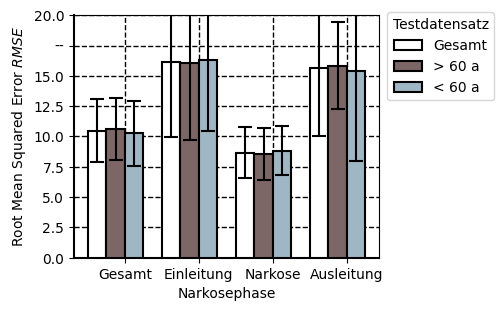

In [14]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','> 60 a', '< 60 a']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, old_rep, young_rep]
report_std = [all_rep_std, old_rep_std, young_rep_std]


for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.4, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20.0)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('age_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()

# Testing Gender

## Male

In [15]:
male_rep = phases_report(y_pred[m_index_test], bis.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test])
male_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,105.19,122.47,7.50,6.94,10.26,11.07
Induction,257.46,600.22,12.55,17.60,16.05,24.50
Maintenance,73.34,53.44,6.50,5.27,8.56,7.31
Recovery,245.51,335.83,11.73,12.74,15.67,18.33


In [16]:
male_rep_std = phases_report_std(male_rep,y_pred[m_index_test], bis.test_dataset[m_index_test], propofolrate.test_dataset[m_index_test])
male_rep_std

All      	min: 	 9 	max: 	 15
Induction 	min: 	 17 	max: 	 6
Maintenance 	min: 	 8 	max: 	 10
Recovery 	min: 	 13 	max: 	 16


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,57.24,64.46,2.00,1.66,2.62,2.78
Induction,263.48,399.51,5.92,8.34,6.19,7.32
Maintenance,39.69,31.24,1.66,1.50,2.16,2.00
Recovery,156.04,179.52,5.06,5.99,5.94,6.45


## Female

In [17]:
fem_rep = phases_report(y_pred[f_index_test], bis.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test])
fem_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,128.31,208.12,8.69,9.94,11.33,14.43
Induction,274.82,750.27,13.08,20.57,16.58,27.39
Maintenance,83.14,93.06,7.30,7.47,9.12,9.65
Recovery,251.91,428.86,12.60,15.33,15.87,20.71


In [18]:
fem_rep_std = phases_report_std(fem_rep,y_pred[f_index_test], bis.test_dataset[f_index_test], propofolrate.test_dataset[f_index_test])
fem_rep_std

All      	min: 	 3 	max: 	 2
Induction 	min: 	 4 	max: 	 1
Maintenance 	min: 	 5 	max: 	 2
Recovery 	min: 	 3 	max: 	 5


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,50.15,91.01,2.14,3.19,2.37,3.50
Induction,238.14,397.72,5.84,8.44,6.18,6.71
Maintenance,37.90,53.11,2.01,2.77,1.87,2.82
Recovery,112.13,186.30,4.75,6.45,4.78,6.04


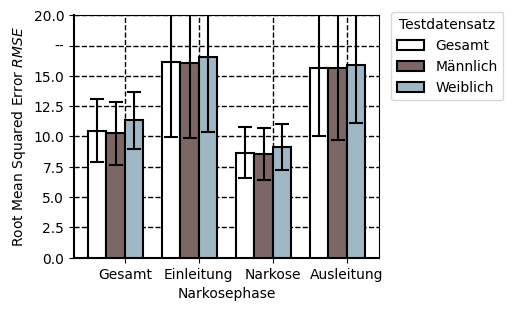

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','Männlich', 'Weiblich']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, male_rep, fem_rep]
report_std = [all_rep_std, male_rep_std, fem_rep_std]

for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.43, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('gender_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()

# BIS Verteilung M/W

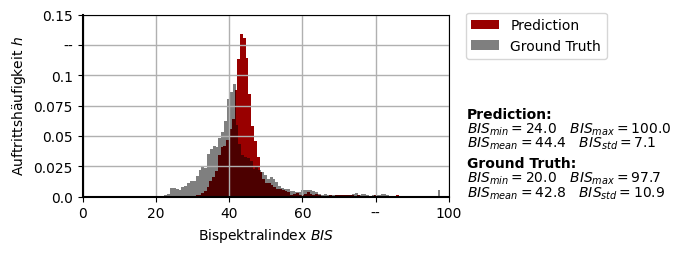

In [20]:
from utils.plotting import full_histogramm_plot

plot = full_histogramm_plot(groundtruth = bis.test_dataset[m_index_test], prediction = y_pred[m_index_test], filename='histogramm_m.pdf')
plot.show()

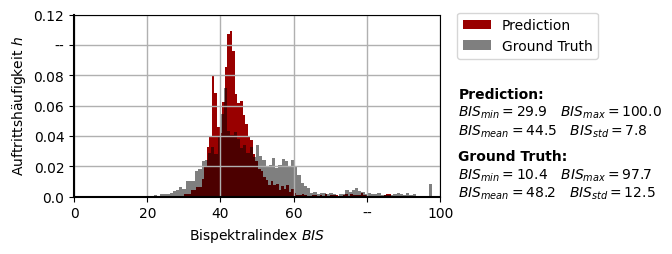

In [21]:
plot = full_histogramm_plot(groundtruth = bis.test_dataset[f_index_test], prediction = y_pred[f_index_test], filename='histogramm_f.pdf')
plot.show()

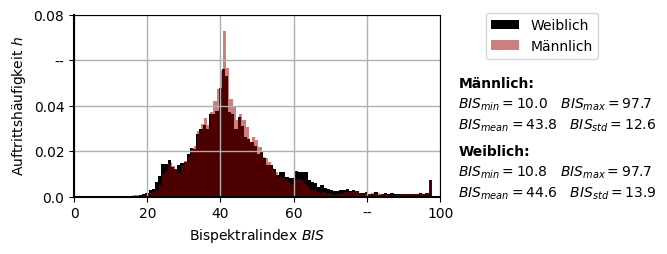

In [22]:
timefilter_m = (bis.train_dataset[m_index_train] == 0.0).flatten()
timefilter_f = (bis.train_dataset[f_index_train] == 0.0).flatten()

y_pred_m = bis.train_dataset[m_index_train].flatten()
y_pred_m[timefilter_m] = np.nan

y_pred_f = bis.train_dataset[f_index_train].flatten()
y_pred_f[timefilter_f] = np.nan

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams['font.size'] = 10

plt.hist(y_pred_f, bins=100, density=True, color=color1, label='Weiblich')
plt.hist(y_pred_m, bins=100, density=True, color=color5, label='Männlich', alpha=0.5)


plt.xlabel('Bispektralindex $BIS$')
plt.ylabel('Auftrittshäufigkeit $h$')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05))


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=100)

# Einheiten auf x-Achse
xunit = '--'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float('{:.3f}'.format(tick)) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

pred_max = np.nanmax(y_pred_m)
pred_min = np.nanmin(y_pred_m)
pred_mean = np.nanmean(y_pred_m)
pred_std = np.nanstd(y_pred_m)

ground_max = np.nanmax(y_pred_f)
ground_min = np.nanmin(y_pred_f)
ground_mean = np.nanmean(y_pred_f)
ground_std = np.nanstd(y_pred_f)

t = 105

plt.text(t, 0.048, s='Männlich:', fontweight='bold')
plt.text(t, 0.039, s='$BIS_{min}  = $' + '${:.1f}$'.format(pred_min)  + '$\quad BIS_{max} = $' + '${:.1f}$'.format(pred_max))
plt.text(t, 0.030, s='$BIS_{mean} = $' + '${:.1f}$'.format(pred_mean) + '$\quad BIS_{std} = $' + '${:.1f}$'.format(pred_std))

plt.text(t, 0.018, s='Weiblich:', fontweight='bold')
plt.text(t, 0.009, s='$BIS_{min}  = $' + '${:.1f}$'.format(ground_min)  + '$\quad BIS_{max} = $' + '${:.1f}$'.format(ground_max))
plt.text(t, 0.000, s='$BIS_{mean} = $' + '${:.1f}$'.format(ground_mean) + '$\quad BIS_{std} = $' + '${:.1f}$'.format(ground_std))

plt.savefig('test.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

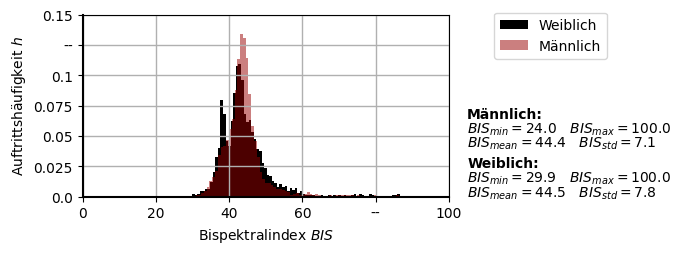

In [23]:
timefilter_m = (y_pred[m_index_test] == 0.0).flatten()
timefilter_f = (y_pred[f_index_test] == 0.0).flatten()

y_pred_m = y_pred[m_index_test].flatten()
y_pred_m[timefilter_m] = np.nan

y_pred_f = y_pred[f_index_test].flatten()
y_pred_f[timefilter_f] = np.nan

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.figure(figsize=(12/2.54, 6/2.54))
plt.rcParams['font.size'] = 10

plt.hist(y_pred_f, bins=100, density=True, color=color1, label='Weiblich')
plt.hist(y_pred_m, bins=100, density=True, color=color5, label='Männlich', alpha=0.5)


plt.xlabel('Bispektralindex $BIS$')
plt.ylabel('Auftrittshäufigkeit $h$')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 1.05))


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0)
ax.set_xlim(left=0, right=100)

# Einheiten auf x-Achse
xunit = '--'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float('{:.3f}'.format(tick)) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

pred_max = np.nanmax(y_pred_m)
pred_min = np.nanmin(y_pred_m)
pred_mean = np.nanmean(y_pred_m)
pred_std = np.nanstd(y_pred_m)

ground_max = np.nanmax(y_pred_f)
ground_min = np.nanmin(y_pred_f)
ground_mean = np.nanmean(y_pred_f)
ground_std = np.nanstd(y_pred_f)

t = 105

plt.text(t, 0.065, s='Männlich:', fontweight='bold')
plt.text(t, 0.053, s='$BIS_{min}  = $' + '${:.1f}$'.format(pred_min)  + '$\quad BIS_{max} = $' + '${:.1f}$'.format(pred_max))
plt.text(t, 0.041, s='$BIS_{mean} = $' + '${:.1f}$'.format(pred_mean) + '$\quad BIS_{std} = $' + '${:.1f}$'.format(pred_std))

plt.text(t, 0.024, s='Weiblich:', fontweight='bold')
plt.text(t, 0.012, s='$BIS_{min}  = $' + '${:.1f}$'.format(ground_min)  + '$\quad BIS_{max} = $' + '${:.1f}$'.format(ground_max))
plt.text(t, 0.000, s='$BIS_{mean} = $' + '${:.1f}$'.format(ground_mean) + '$\quad BIS_{std} = $' + '${:.1f}$'.format(ground_std))

plt.savefig('test.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')

# Propofolinfusionen Vergleich

In [24]:
proprate_m = np.concatenate((propofolrate.train_dataset[m_index_train], propofolrate.validation_dataset[m_index_val], propofolrate.test_dataset[m_index_test]), axis=0)
info_m = np.concatenate((info_non_norm.train_dataset[m_index_train], info_non_norm.validation_dataset[m_index_val], info_non_norm.test_dataset[m_index_test]), axis=0)
proprate_m = proprate_m[:,:,0] * 20          # in mg/h 
weight_m = info_m[:,3][np.newaxis].T    # in kg
rate_norm_m = proprate_m / weight_m                                         # in mg/h

proprate_f = np.concatenate((propofolrate.train_dataset[f_index_train], propofolrate.validation_dataset[f_index_val], propofolrate.test_dataset[f_index_test]), axis=0)
info_f = np.concatenate((info_non_norm.train_dataset[f_index_train], info_non_norm.validation_dataset[f_index_val], info_non_norm.test_dataset[f_index_test]), axis=0)
proprate_f = proprate_f[:,:,0] * 20          # in mg/h
weight_f = info_f[:,3][np.newaxis].T    # in kg
rate_norm_f = proprate_f / weight_f                                         # in mg/h

timefilter_m = np.logical_or(rate_norm_m < 1, rate_norm_m > 15)             # Nach LAR16a
timefilter_f = np.logical_or(rate_norm_f < 1, rate_norm_f > 15)

rate_norm_m[timefilter_m] = np.nan
rate_norm_f[timefilter_f] = np.nan

print("Mean:\t M: {:.3f}\tF: {:.3f}".format(np.nanmean(rate_norm_m), np.nanmean(rate_norm_f)))
print("Std:\t M: {:.3f}\tF: {:.3f}".format(np.nanstd(rate_norm_m), np.nanstd(rate_norm_f)))
print("N:\t M: {:.3f}\tF: {:.3f}".format(rate_norm_m.shape[0], rate_norm_f.shape[0]))

Mean:	 M: 6.396	F: 6.358
Std:	 M: 2.105	F: 2.085
N:	 M: 104.000	F: 51.000


# Testing BMI

## BMI >= 23

In [25]:
bmi1_rep = phases_report(y_pred[bmi_1_index_test], bis.test_dataset[bmi_1_index_test], propofolrate.test_dataset[bmi_1_index_test])
bmi1_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,100.53,126.33,7.58,7.43,10.03,11.24
Induction,234.85,639.75,12.14,18.16,15.32,25.29
Maintenance,73.66,59.81,6.67,5.86,8.58,7.73
Recovery,233.81,341.38,12.00,13.50,15.29,18.48


In [26]:
bmi1_rep_std = phases_report_std(bmi1_rep,y_pred[bmi_1_index_test], bis.test_dataset[bmi_1_index_test], propofolrate.test_dataset[bmi_1_index_test])
bmi1_rep_std

All      	min: 	 8 	max: 	 4
Induction 	min: 	 11 	max: 	 3
Maintenance 	min: 	 6 	max: 	 4
Recovery 	min: 	 9 	max: 	 10


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,55.13,90.43,2.37,3.20,2.63,3.61
Induction,200.75,394.25,5.01,7.98,5.46,7.38
Maintenance,46.44,49.43,2.18,2.65,2.47,2.78
Recovery,129.36,207.13,4.85,7.28,5.27,7.14


## BMI < 23

In [27]:
bmi2_rep = phases_report(y_pred[bmi_2_index_test], bis.test_dataset[bmi_2_index_test], propofolrate.test_dataset[bmi_2_index_test])
bmi2_rep

,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,121.94,157.32,7.96,7.71,11.04,12.54
Induction,287.77,635.51,13.20,18.51,16.96,25.21
Maintenance,77.31,62.42,6.61,5.44,8.79,7.90
Recovery,259.64,380.12,11.94,13.42,16.11,19.50


In [28]:
bmi2_rep_std = phases_report_std(bmi2_rep,y_pred[bmi_2_index_test], bis.test_dataset[bmi_2_index_test], propofolrate.test_dataset[bmi_2_index_test])
bmi2_rep_std

All      	min: 	 2 	max: 	 0
Induction 	min: 	 9 	max: 	 4
Maintenance 	min: 	 9 	max: 	 7
Recovery 	min: 	 5 	max: 	 10


,Prediction MSE,Baseline MSE,Prediction MAE,Baseline MAE,Prediction RMSE,Baseline RMSE
All,56.61,70.95,1.80,1.64,2.52,2.82
Induction,301.21,413.05,6.63,8.88,6.79,7.20
Maintenance,31.35,35.67,1.28,1.43,1.69,2.20
Recovery,160.81,158.82,5.19,5.06,6.06,5.57


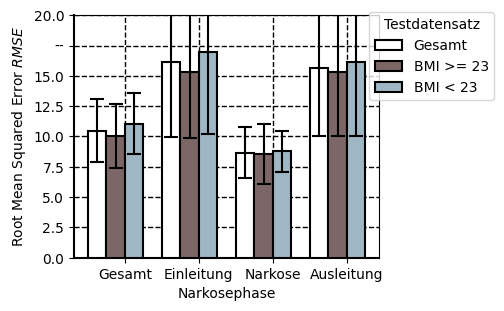

In [29]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

### Plot

fig = plt.figure(figsize=(10/2.54, 8/2.54))
label = ['Gesamt','BMI >= 23', 'BMI < 23']
x_label = ['Gesamt','Einleitung', 'Narkose', 'Ausleitung']

x = np.arange(len(x_label))  # the label locations
width = 0.25  # the width of the bars
multiplier = -1.5

color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

colors =  [color2, color4, color3]
report = [all_rep, bmi1_rep, bmi2_rep]
report_std = [all_rep_std, bmi1_rep_std, bmi2_rep_std]


for rep, rep_std, color, lab in zip(report, report_std, colors, label):
    offset = width * multiplier
    rects = plt.bar(x + offset, list(rep["Prediction RMSE"]), width, label=lab, color=color, edgecolor='black', linewidth=1.5, zorder=3)
    plt.errorbar(x + offset, list(rep["Prediction RMSE"]), yerr=list(rep_std["Prediction RMSE"]), fmt='none', ecolor='black', elinewidth=1.5, capsize=5, capthick=1.5, zorder=4)
    multiplier += 1

plt.legend(title='Testdatensatz', loc='upper right', ncol=1, bbox_to_anchor=(1.4, 1.04))

plt.ylabel('Root Mean Squared Error $RMSE$')
plt.xlabel('Narkosephase')
plt.grid(True, linestyle='--',color='k', linewidth=1, zorder=0)


# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20.0)

# Einheiten auf y-Achse
yunit = '--'
ticks = list(range(0, 210, 25))
ticks = [tick/10 for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

ax.set_xticks(x)
ax.set_xticklabels(x_label)

plt.grid(axis='y', linewidth=1.0)

x = 3.9
#plt.text(x, 0, s='Modell: VProp', fontsize=10, fontweight='bold')

plt.savefig('bmi_rmse.pdf', bbox_inches='tight', pad_inches=0.2, format='pdf')
plt.show()

# Einzelfehler

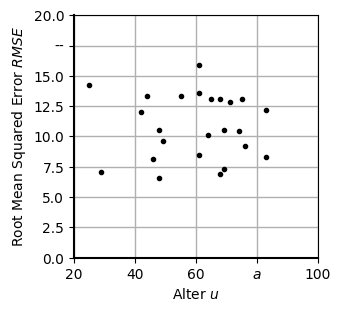

In [30]:
rmse = []
for i, data in enumerate(bis.test_dataset):
    rmse.append(phases_report(y_pred[i:i+1], bis.test_dataset[i:i+1], propofolrate.test_dataset[i:i+1])['Prediction RMSE']['All'])

rmse = np.array(rmse)

columns = ['sex','age','height','weight','bmi']

plt.figure(figsize=(8/2.54, 8/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(info_non_norm.test_dataset[:,1],rmse, '.', color=color1, label='RMSE')

plt.xlabel('Alter $u$')
plt.ylabel('Root Mean Squared Error $RMSE$')

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)
ax.set_xlim(left=20, right=100)

# Einheiten auf x-Achse
xunit = '$a$'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float(tick) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

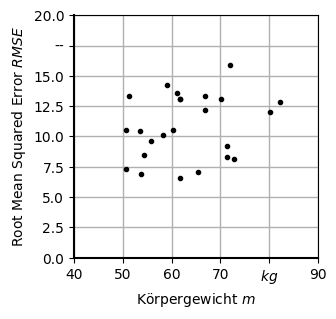

In [31]:
rmse = []
for i, data in enumerate(bis.test_dataset):
    rmse.append(phases_report(y_pred[i:i+1], bis.test_dataset[i:i+1], propofolrate.test_dataset[i:i+1])['Prediction RMSE']['All'])

rmse = np.array(rmse)

columns = ['sex','age','height','weight','bmi']

plt.figure(figsize=(8/2.54, 8/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(info_non_norm.test_dataset[:,3],rmse, '.', color=color1, label='RMSE')

plt.xlabel('Körpergewicht $m$')
plt.ylabel('Root Mean Squared Error $RMSE$')

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)
ax.set_xlim(left=40, right=90)

# Einheiten auf x-Achse
xunit = '$kg$'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float(tick) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)

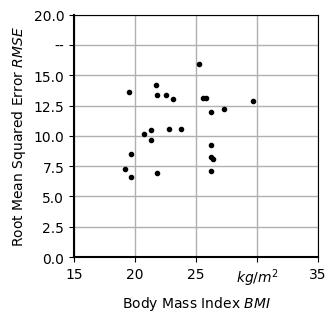

In [32]:
rmse = []
for i, data in enumerate(bis.test_dataset):
    rmse.append(phases_report(y_pred[i:i+1], bis.test_dataset[i:i+1], propofolrate.test_dataset[i:i+1])['Prediction RMSE']['All'])

rmse = np.array(rmse)

columns = ['sex','age','height','weight','bmi']

plt.figure(figsize=(8/2.54, 8/2.54))
plt.rcParams['font.size'] = 10

# Colors
color1 = (0, 0, 0)
color2 = (1, 1, 1)
color3 = (159/255, 182/255, 196/255)
color4 = (125/255, 102/255, 102/255)
color5 = (153/255, 0, 0)

plt.plot(info_non_norm.test_dataset[:,4],rmse, '.', color=color1, label='RMSE')

plt.xlabel('Body Mass Index $BMI$')
plt.ylabel('Root Mean Squared Error $RMSE$')

# Axis settings
ax = plt.gca()
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.set_ylim(bottom=0, top=20)
ax.set_xlim(left=15, right=35)

# Einheiten auf x-Achse
xunit = '$kg/m^2$'
ticks = ax.get_xticks()
ticks = [int(tick) for tick in ticks]
ticks_with_units = [xunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_xticks(ticks)
ax.set_xticklabels(ticks_with_units)

# Einheiten auf y-Achse
yunit = '--'
ticks = ax.get_yticks()
ticks = [float(tick) for tick in ticks]
ticks_with_units = [yunit if i == len(ticks) - 2 else ticks[i] for i in range(len(ticks))]
ax.set_yticks(ticks)
ax.set_yticklabels(ticks_with_units)

plt.grid(True, linewidth=1.0)